<a href="https://colab.research.google.com/github/IdealisticINTJ/My_Machine_Learning_Projects/blob/main/Anime_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle8"

In [4]:
%cd /content/gdrive/My Drive/Kaggle8

/content/gdrive/My Drive/Kaggle8


In [5]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 96% 24.0M/25.0M [00:00<00:00, 50.7MB/s]
100% 25.0M/25.0M [00:00<00:00, 50.4MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [7]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

In [8]:
data = pd.read_csv("anime.csv")
rating = pd.read_csv("rating.csv")
data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [9]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [10]:
data.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [11]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [12]:
rating.rating.value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

In [13]:
rating = rating[rating["rating"] != -1]
print(f"data.csv - rows: {data.shape[0]}, columns: {data.shape[1]}")
print(f"rating.csv - rows: {rating.shape[0]}, columns: {rating.shape[1]}")

data.csv - rows: 12294, columns: 7
rating.csv - rows: 6337241, columns: 3


In [14]:
genre=data['genre'].values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


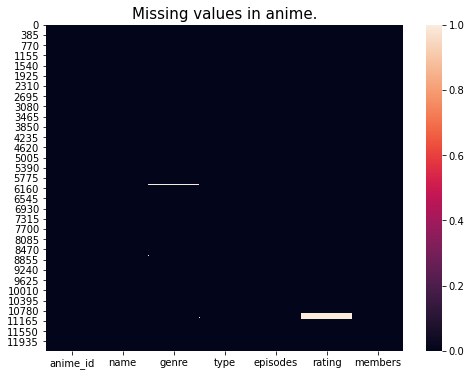

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(data.isnull())
plt.title("Missing values in anime.", fontsize = 15)
plt.show()

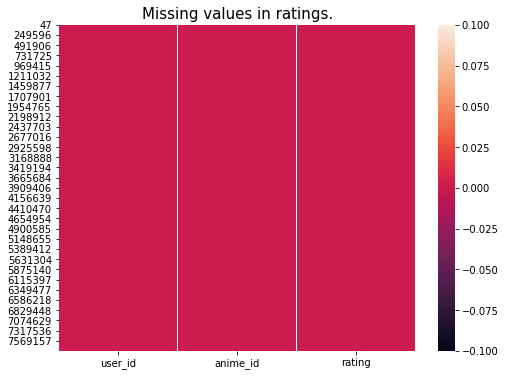

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(rating.isnull())
plt.title("Missing values in ratings.", fontsize = 15)
plt.show()

In [17]:
df = pd.merge(rating,data[["anime_id","name"]], left_on = "anime_id", right_on = "anime_id").drop("anime_id", axis = 1)
df.head()

,user_id,rating,name
0,1,10,Highschool of the Dead
1,3,6,Highschool of the Dead
2,5,2,Highschool of the Dead
3,12,6,Highschool of the Dead
4,14,6,Highschool of the Dead


In [18]:
count_rating = df.groupby("name")["rating"].count().sort_values(ascending = False)
count_rating

name
Death Note                         34226
Sword Art Online                   26310
Shingeki no Kyojin                 25290
Code Geass: Hangyaku no Lelouch    24126
Angel Beats!                       23565
                                   ...  
Ashita no Eleventachi                  1
Ashita e Mukau Hito                    1
Shounen Ninja Kaze no Fujimaru         1
Hi no Tori: Hagoromo-hen               1
Mechakko Dotakon                       1
Name: rating, Length: 9926, dtype: int64

In [19]:
# Some animes that have only 1 rating better be ignored by the recommender system.
# Therefore, anime that have above a certain rating, i.e. min will be considered.
min = 5000
more_than_min_ratings = count_rating[count_rating.apply(lambda x: x >= min)].index

# Keeping only the animes with at least 'min' ratings in the DataFrame, we get:
df_min = df[df['name'].apply(lambda x: x in more_than_min_ratings)]

In [21]:
before = len(df.name.unique())
after = len(df_min.name.unique())
rows_before = df.shape[0]
rows_after = df_min.shape[0]
print(f'''There were {before} animes in the dataset before filtering and {after} animes after the filtering.

{before} animes => {after} animes
{rows_before} rows before filtering => {rows_after} rows after filtering''')

There were 9926 animes in the dataset before filtering and 279 animes after the filtering.

9926 animes => 279 animes
6337239 rows before filtering => 2517097 rows after filtering


### **Content-based, collaborative Recommendation System**

In [22]:
df_recom = df_min.pivot_table(index='user_id',columns='name',values='rating')
df_recom.iloc[:5,:5]


name,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!
user_id,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,7.0,6.0,NaN,NaN,8.0
5,3.0,NaN,NaN,NaN,4.0
7,8.0,NaN,NaN,NaN,NaN


In [23]:
df_min.name.value_counts().head(15)

Death Note                            34226
Sword Art Online                      26310
Shingeki no Kyojin                    25290
Code Geass: Hangyaku no Lelouch       24126
Angel Beats!                          23565
Elfen Lied                            23528
Naruto                                22071
Fullmetal Alchemist: Brotherhood      21494
Fullmetal Alchemist                   21332
Code Geass: Hangyaku no Lelouch R2    21124
Toradora!                             20837
Highschool of the Dead                19488
Sen to Chihiro no Kamikakushi         19481
Clannad                               18746
Mirai Nikki (TV)                      18649
Name: name, dtype: int64

In [24]:
def find_corr(df, name):
    similar_to_movie = df.corrwith(df[name])
    similar_to_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    similar_to_movie = similar_to_movie.sort_values(by = 'Correlation', ascending = False)
    return similar_to_movie
    

In [25]:
anime1 = 'Naruto'
find_corr(df_recom, anime1).head(33)

,Correlation
name,
Naruto,1.000000
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!,0.582344
Naruto: Shippuuden Movie 1,0.578797
Bleach,0.547983
Fairy Tail,0.444271
Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru,0.439225
Dragon Ball Z,0.437442
InuYasha,0.433100
Dragon Ball GT,0.429704


In [33]:
find_corr(df_recom, anime1).tail(33)

,Correlation
name,
Steins;Gate,0.156113
Ookami to Koushinryou II,0.154742
Evangelion: 1.0 You Are (Not) Alone,0.151978
Mononoke Hime,0.147982
Hotaru no Haka,0.145070
Monogatari Series: Second Season,0.140743
Azumanga Daioh,0.138831
Tengen Toppa Gurren Lagann,0.137932
Fate/Zero 2nd Season,0.136991


In [28]:
anime2 = 'Steins;Gate'
find_corr(df_recom, anime2).head(33)

,Correlation
name,
Steins;Gate,1.000000
Steins;Gate: Oukoubakko no Poriomania,0.589772
Steins;Gate Movie: Fuka Ryouiki no Déjà vu,0.549186
Suzumiya Haruhi no Shoushitsu,0.366565
Higurashi no Naku Koro ni Kai,0.354278
Psycho-Pass,0.351529
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,0.348431
Fate/Zero 2nd Season,0.344418
Fate/stay night: Unlimited Blade Works,0.337731


In [34]:
find_corr(df_recom, anime2).tail(33)

,Correlation
name,
Paprika,0.171751
Mahouka Koukou no Rettousei,0.170590
High School DxD New,0.170530
Akame ga Kill!,0.170350
Vampire Knight,0.169833
Ghost in the Shell: Stand Alone Complex,0.169006
InuYasha,0.168345
Ichiban Ushiro no Daimaou,0.166692
Pokemon,0.166122


In [30]:
# Recommended animes to watch after Clannad: *Clannad (Drama, Fantasy, Romance, Slice of Life, Supernatural) 
# was heart-wrenching, similar ones are as follows:
anime3 = 'Clannad'
find_corr(df_recom, anime3).head(33)

,Correlation
name,
Clannad,1.000000
Clannad: After Story,0.669672
"Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen",0.523434
Kanon (2006),0.508144
"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",0.499767
Angel Beats!,0.402977
Shakugan no Shana II (Second),0.394981
Shakugan no Shana,0.394631
Air,0.382908


In [32]:
# Not recommended for the ones who like Clannad: basically, the genres differ.
find_corr(df_recom, anime3).tail(33)

,Correlation
name,
School Days,0.205977
Gantz,0.205766
One Punch Man,0.202124
Howl no Ugoku Shiro,0.199553
Pokemon,0.199158
Nana,0.197136
Pokemon: Mewtwo no Gyakushuu,0.196910
Fullmetal Alchemist: Brotherhood,0.196472
Majo no Takkyuubin,0.194182
